# Used car price prediction using Catboost Regressor

## imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

## Preprocessing

In [2]:
dataset= pd.read_csv('C:/Users/prana/OneDrive/Документы/WBS/final_project/used_car_price_prediction/data/vehicles.csv')

In [3]:
dataset.shape

(426880, 26)

Certain columns like ID, URL are irrelevant for this model.

In [4]:
non_related_columns = ['id', 'url' , 'region', 'region_url', 'VIN', 'image_url', 'county', 'state', 'lat', 'long', 'description']
data = dataset.drop(columns= non_related_columns)

In [5]:
data.shape

(426880, 15)

#todo We can convert regions occurying in less than 100 records to 'other', and then include region in the model.

In [6]:
dataset['region'].value_counts().tail(20)

siskiyou county        83
north platte           80
clovis / portales      78
ogden-clearfield       76
eastern montana        75
provo / orem           75
western IL             63
oneonta                62
southwest MN           56
pierre / central SD    55
eastern CO             40
southern WV            36
st louis               35
northeast SD           34
southwest TX           30
meridian               28
southwest MS           14
kansas city            11
fort smith, AR          9
west virginia (old)     8
Name: region, dtype: int64

Let us check for NANs

In [7]:
dataset.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [8]:
data.isna().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
posting_date        68
dtype: int64

It is not possible to interpolate NANs for certain features like Condition, Year and Odometer. Hence, deleting them.

In [9]:
data_v2 = data.dropna(subset =['condition', 'year', 'odometer'])

In [10]:
data_v2.shape

(250851, 15)

In [11]:
data_v2['manufacturer'].value_counts()

ford               37563
chevrolet          32208
toyota             20460
honda              12835
nissan             11015
jeep               10442
gmc                 9390
bmw                 9155
ram                 8144
dodge               7590
mercedes-benz       6560
volkswagen          6232
hyundai             5997
subaru              5542
lexus               5280
audi                5217
kia                 4912
cadillac            4489
acura               4477
chrysler            3653
buick               3640
mazda               3591
infiniti            3552
lincoln             3049
volvo               2475
mitsubishi          2327
mini                1598
jaguar              1568
pontiac             1484
rover               1181
mercury              839
alfa-romeo           747
porsche              733
saturn               700
tesla                668
fiat                 566
harley-davidson       84
datsun                41
ferrari               41
aston-martin          12


Dropping certain manufacturers, since not many records are available for them.

In [12]:
drop_manufacturer = ['tesla', 'fiat','harley-davidson', 'ferrari', 'datson', 'aston-martin', 'land rover', 'morgan', 'datsun']

In [13]:
data_v2 = data_v2[~data_v2['manufacturer'].isin(drop_manufacturer)]

In [14]:
def impute_feature_values(feature, manufacturer, model):
    result = data_v2.loc[lambda df_ : ((df_['manufacturer'] == manufacturer) & (df_['model'] == model) & (~df_[feature].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,][feature]

In [15]:
data_v4=(
    data_v2
        .assign(re_cylinders = np.where(
            data_v2['cylinders'].isna(),
            impute_feature_values('cylinders', data_v2['manufacturer'],data_v2['model']),
            data_v2['cylinders']
        ))
        .assign(re_fuel = np.where(
            data_v2['fuel'].isna(),
            impute_feature_values('fuel', data_v2['manufacturer'],data_v2['model']),
            data_v2['fuel']
        ))
        .assign(re_transmission = np.where(
            data_v2['transmission'].isna(),
            impute_feature_values('transmission', data_v2['manufacturer'],data_v2['model']),
            data_v2['transmission']
        ))
        .assign(re_drive = np.where(
            data_v2['drive'].isna(),
            impute_feature_values('drive', data_v2['manufacturer'],data_v2['model']),
            data_v2['drive']
        ))
        .assign(re_size = np.where(
            data_v2['size'].isna(),
            impute_feature_values('size', data_v2['manufacturer'],data_v2['model']),
            data_v2['size']
        ))
        .assign(re_type = np.where(
            data_v2['type'].isna(),
            impute_feature_values('type', data_v2['manufacturer'],data_v2['model']),
            data_v2['type']
        ))
)
data_v4.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,...,size,type,paint_color,posting_date,re_cylinders,re_fuel,re_transmission,re_drive,re_size,re_type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,...,NaN,pickup,white,2021-05-04T12:31:18-0500,8 cylinders,gas,other,rwd,full-size,pickup
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,...,NaN,pickup,blue,2021-05-04T12:31:08-0500,8 cylinders,gas,other,rwd,full-size,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,...,NaN,pickup,red,2021-05-04T12:31:25-0500,8 cylinders,gas,other,rwd,full-size,pickup
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,...,NaN,pickup,red,2021-05-04T10:41:31-0500,8 cylinders,gas,other,rwd,full-size,pickup
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,...,full-size,truck,black,2021-05-03T14:02:03-0500,6 cylinders,gas,automatic,rwd,full-size,truck


In [16]:
data_v4.isna().sum()

price                   0
year                    0
manufacturer        10782
model                2253
condition               0
cylinders           69611
fuel                   16
odometer                0
title_status         5462
transmission           34
drive               60567
size               153376
type                32377
paint_color         50733
posting_date            0
re_cylinders            0
re_fuel                 0
re_transmission         0
re_drive                0
re_size                 0
re_type                 0
dtype: int64

Imputing NANs for Model is difficult, so let us just drop them. But let us try to impute NANs for Manufaturer using the Model and other details

In [17]:
def find_manufacturer(model, cylinders, fuel, transmission, type):
    result = data_v4.loc[lambda df_ : ((df_['model'] == model) & (df_['re_cylinders'] == cylinders) &(df_['re_fuel'] == fuel) &
                                       (df_['re_transmission'] == transmission)&(df_['re_type'] == type) &
                                       (~df_['manufacturer'].isna()))]
    if result.shape[0] == 0:
        return np.nan
    return result.iloc[0,]['manufacturer']

In [18]:
data_v5 =(
    data_v4
        .assign(re_manufacturer = np.where(
            data_v4['manufacturer'].isna(),
            find_manufacturer(data_v4['model'],data_v4['re_cylinders'], data_v4['re_fuel'], data_v4['re_transmission'], data_v4['re_type']),
            data_v4['manufacturer']
        ))
)

In [19]:
data_v5.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'posting_date', 're_cylinders', 're_fuel',
       're_transmission', 're_drive', 're_size', 're_type', 're_manufacturer'],
      dtype='object')

Let us now drop NANs for Model and TitleStatus features

In [20]:
data_v5.dropna(subset= ['model', 'title_status'], inplace=True)
columns= ['price', 'year', 're_manufacturer', 'model', 'condition', 're_cylinders', 're_fuel', 'odometer', 'title_status', 're_transmission', 're_drive', 're_size', 're_type', 'posting_date' ,'paint_color']
data_v6 = data_v5[columns]
data_v6.columns = data_v6.columns.str.replace('re_', '')

In [21]:
data_v6.isna().sum()

price               0
year                0
manufacturer        0
model               0
condition           0
cylinders           0
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
posting_date        0
paint_color     44602
dtype: int64

In [22]:
data_v6.shape

(241719, 15)

Let us impute paint color by 'none'.

In [23]:
data_v6['paint_color'].fillna(value='none', inplace=True)

C:\Users\prana\AppData\Local\Temp\ipykernel_19984\3501033760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['paint_color'].fillna(value='none', inplace=True)


In [24]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  object 
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 29.5+ MB


### Categorical Variables

In [25]:
data_v6['posting_date']

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 241719, dtype: object

Convert posting_date column to datetime format


In [26]:
data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)

C:\Users\prana\AppData\Local\Temp\ipykernel_19984\4100576747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date']= pd.to_datetime(data_v6['posting_date'] , utc=True)


Then convert it to integer, because we want to use this column for the model.

In [27]:
data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


C:\Users\prana\AppData\Local\Temp\ipykernel_19984\4181322438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['posting_date'] = data_v6['posting_date'].dt.year*10000 + data_v6['posting_date'].dt.month*100 + data_v6['posting_date'].dt.day


In [28]:
data_v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241719 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   condition     241719 non-null  object 
 5   cylinders     241719 non-null  object 
 6   fuel          241719 non-null  object 
 7   odometer      241719 non-null  float64
 8   title_status  241719 non-null  object 
 9   transmission  241719 non-null  object 
 10  drive         241719 non-null  object 
 11  size          241719 non-null  object 
 12  type          241719 non-null  object 
 13  posting_date  241719 non-null  int64  
 14  paint_color   241719 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 29.5+ MB


Cylinders have some text values, which we do not need. First we scrape the digit part of them, and then we convert them to int.


In [29]:
def other_to_0(input):
    if input == 'other': 
        return '0 cylinders'
    return input

In [30]:
data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)

C:\Users\prana\AppData\Local\Temp\ipykernel_19984\2967395791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].apply(other_to_0)


In [31]:
data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')

C:\Users\prana\AppData\Local\Temp\ipykernel_19984\1092821188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v6['cylinders'] = data_v6['cylinders'].str.replace(r'(\d{1,2})(\s)(.*)$', r'\1', regex=True).astype('int64')


Let us now handle categorical features


In [32]:
data_v6['condition'].unique()

array(['good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [33]:
data_v6['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [34]:
data_v6['title_status'].unique()

array(['clean', 'rebuilt', 'lien', 'salvage', 'missing', 'parts only'],
      dtype=object)

In [35]:
data_v6['transmission'].unique()

array(['other', 'automatic', 'manual'], dtype=object)

In [36]:
data_v6['drive'].unique()

array(['rwd', '4wd', 'fwd'], dtype=object)

In [37]:
data_v6['size'].unique()

array(['full-size', 'mid-size', 'compact', 'sub-compact'], dtype=object)

In [38]:
data_v6['paint_color'].unique()

array(['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [39]:
data_v6.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'posting_date', 'paint_color'],
      dtype='object')

In [40]:
#ordinal encoder list
ordinal_columns= ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'paint_color']


ord_condition_list = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
ord_fuel_list = ['other', 'diesel', 'gas', 'hybrid', 'electric']
ord_title_status_list = ['salvage', 'missing', 'parts only', 'rebuilt', 'lien', 'clean']
ord_tranmission_list = ['other', 'manual', 'automatic']
ord_drive_list= ['fwd', 'rwd', '4wd']
ord_size_list = ['mid-size','full-size', 'sub-compact', 'compact']
ord_paint_color = ['white', 'blue', 'red', 'black', 'silver', 'grey', 'none', 'brown',
                   'yellow', 'orange', 'green', 'custom', 'purple']
ordinal_lists = [ord_condition_list,ord_fuel_list,ord_title_status_list,ord_tranmission_list,ord_drive_list,ord_size_list,ord_paint_color]

Train and fit Ordinal Encoder

In [41]:
ct_ordinal= ColumnTransformer([("ordinal", OrdinalEncoder(categories=ordinal_lists),ordinal_columns)])
ct_ordinal.fit(data_v6)

ColumnTransformer(transformers=[('ordinal',
                                 OrdinalEncoder(categories=[['salvage', 'fair',
                                                             'good',
                                                             'excellent',
                                                             'like new',
                                                             'new'],
                                                            ['other', 'diesel',
                                                             'gas', 'hybrid',
                                                             'electric'],
                                                            ['salvage',
                                                             'missing',
                                                             'parts only',
                                                             'rebuilt', 'lien',
                                                             'clean'],
                                                            ['other', 'manual',
                                                             'automatic'],
                                                            ['fwd', 'rwd',
                                                             '4wd'],
                                                            ['mid-size',
                                                             'full-size',
                                                             'sub-compact',
                                                             'compact'],
                                                            ['white', 'blue',
                                                             'red', 'black',
                                                             'silver', 'grey',
                                                             'none', 'brown',
                                                             'yellow', 'orange',
                                                             'green', 'custom',
                                                             'purple']]),
                                 ['condition', 'fuel', 'title_status',
                                  'transmission', 'drive', 'size',
                                  'paint_color'])])

In [42]:
ordinal_df = pd.DataFrame(ct_ordinal.transform(data_v6), columns= ordinal_columns)

data_v7 = data_v6.copy()
data_v7.reset_index(inplace=True, drop=True)
data_v7.drop(columns=ordinal_columns, inplace= True) 
data_v7[ordinal_columns]= ordinal_df[ordinal_columns]
data_v7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241719 entries, 0 to 241718
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         241719 non-null  int64  
 1   year          241719 non-null  float64
 2   manufacturer  241719 non-null  object 
 3   model         241719 non-null  object 
 4   cylinders     241719 non-null  int64  
 5   odometer      241719 non-null  float64
 6   type          241719 non-null  object 
 7   posting_date  241719 non-null  int64  
 8   condition     241719 non-null  float64
 9   fuel          241719 non-null  float64
 10  title_status  241719 non-null  float64
 11  transmission  241719 non-null  float64
 12  drive         241719 non-null  float64
 13  size          241719 non-null  float64
 14  paint_color   241719 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 27.7+ MB


In [43]:
data_v7.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,2.417190e+05,241719.000000,241719.000000,2.417190e+05,2.417190e+05,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000,241719.000000
mean,6.151027e+04,2010.733703,6.570108,9.732563e+04,2.021044e+07,2.541662,1.788767,4.892644,1.462504,1.020578,0.993128,3.343192
std,1.128491e+07,9.831953,1.643879,2.146261e+05,3.763783e+01,0.720952,0.621617,0.605503,0.850551,0.765271,0.569998,2.663288
min,0.000000e+00,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.500000e+03,2008.000000,6.000000,3.394600e+04,2.021042e+07,2.000000,2.000000,5.000000,1.000000,0.000000,1.000000,1.000000
50%,1.450000e+04,2013.000000,8.000000,8.339400e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,2.699000e+04,2017.000000,8.000000,1.350435e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,6.000000
max,3.736929e+09,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,12.000000


### Outlier

There are many records with price of 0. And a few records with very high prices. Let us drop these outliers.


In [44]:
data_v8 =data_v7[(data_v7['price']> 1000) & (data_v7['price'] < 100000)]
data_v8

,price,year,manufacturer,model,cylinders,odometer,type,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
0,33590,2014.0,gmc,sierra 1500 crew cab slt,8,57923.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,0.0
1,22590,2010.0,chevrolet,silverado 1500,8,71229.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,1.0
2,39590,2020.0,chevrolet,silverado 1500 crew,8,19160.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
3,30990,2017.0,toyota,tundra double cab sr,8,41124.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
4,15000,2013.0,ford,f-150 xlt,6,128000.0,truck,20210503,3.0,2.0,5.0,2.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241714,23590,2019.0,nissan,maxima s sedan 4d,6,32226.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,6.0
241715,30590,2020.0,volvo,s60 t5 momentum sedan 4d,8,12029.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,2.0
241716,34990,2020.0,cadillac,xt4 sport suv 4d,8,4174.0,hatchback,20210404,2.0,1.0,5.0,0.0,1.0,1.0,0.0
241717,28990,2018.0,lexus,es 350 sedan 4d,6,30112.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,4.0


In [45]:
df_filtered = data_v8.copy()
for column in df_filtered.select_dtypes(include="number").columns:
    q_low = df_filtered[column].quantile(0.1)
    q_hi  = df_filtered[column].quantile(0.9)
    data_v9 = df_filtered[(df_filtered[column] < q_hi) & (df_filtered[column] > q_low)]

In [46]:
data_v9.describe()

,price,year,cylinders,odometer,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
count,122035.000000,122035.000000,122035.000000,1.220350e+05,1.220350e+05,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000,122035.000000
mean,17960.317335,2010.986709,6.420322,9.447312e+04,2.021044e+07,2.517663,1.803696,4.880559,1.429090,0.989978,0.992904,2.969214
std,12936.055171,9.212154,1.657810,1.735817e+05,3.785228e+01,0.701707,0.621409,0.629751,0.867508,0.799913,0.632535,1.252349
min,1057.000000,1900.000000,0.000000,0.000000e+00,2.021040e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7194.000000,2008.000000,6.000000,3.442500e+04,2.021042e+07,2.000000,2.000000,5.000000,0.000000,0.000000,1.000000,2.000000
50%,14990.000000,2013.000000,6.000000,8.316000e+04,2.021043e+07,2.000000,2.000000,5.000000,2.000000,1.000000,1.000000,3.000000
75%,26990.000000,2017.000000,8.000000,1.340600e+05,2.021050e+07,3.000000,2.000000,5.000000,2.000000,2.000000,1.000000,4.000000
max,99999.000000,2022.000000,12.000000,1.000000e+07,2.021050e+07,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,5.000000


In [47]:
data_v9_2 = data_v9.reset_index(drop= True)
data_v9_2

,price,year,manufacturer,model,cylinders,odometer,type,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
0,22590,2010.0,chevrolet,silverado 1500,8,71229.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,1.0
1,39590,2020.0,chevrolet,silverado 1500 crew,8,19160.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
2,30990,2017.0,toyota,tundra double cab sr,8,41124.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
3,15000,2013.0,ford,f-150 xlt,6,128000.0,truck,20210503,3.0,2.0,5.0,2.0,1.0,1.0,3.0
4,27990,2012.0,gmc,sierra 2500 hd extended cab,8,68696.0,pickup,20210503,2.0,2.0,5.0,0.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122030,34590,2020.0,alfa-romeo,romeo giulia sedan 4d,8,2498.0,sedan,20210405,2.0,0.0,5.0,0.0,1.0,1.0,3.0
122031,32990,2016.0,infiniti,qx80 sport utility 4d,8,55612.0,other,20210405,2.0,2.0,5.0,2.0,1.0,1.0,3.0
122032,22990,2020.0,hyundai,sonata se sedan 4d,8,3066.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,1.0
122033,30590,2020.0,volvo,s60 t5 momentum sedan 4d,8,12029.0,sedan,20210404,2.0,2.0,5.0,0.0,0.0,1.0,2.0


This is our preprocessed data. We will use this for training.

In [48]:
data_v9_2.to_csv('..\data\data_for_app.csv', index=False)

## Trying out CatBoost for high cardinality features

The preprocessed data still has 3 categorical features, which are high cardinality features. If we one-hot encode them, it gives us dataset with very large number of columns. This causes memory issues while training. Hence, we will use CatBoost, which can internally handle categorical features.

In [49]:
# Seed is used for randomization of processes. With the same seed, we can always reproduce the results.
SEED = 256

In [50]:
# Function to print required metrics
def print_scores(y_train, y_valid, y_pred_train, y_pred_valid):
    train_score = r2_score(y_train, y_pred_train)
    print('------ Train Scores ------')
    print('R2 Score:', train_score)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
    print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

    valid_score = r2_score(y_valid, y_pred_valid)
    print('------ Validation Scores ------')
    print('R2 Score:', valid_score)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, y_pred_valid))
    print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred_valid))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid)))

### Cross Validation

In [51]:
# %%time

# params = {'depth':4,
#           'reg_lambda':6,
#           'loss_function':'RMSE',
#           'eval_metric':'RMSE',
#           'cat_features':cat_features,
#           'task_type':'GPU',
#           'verbose':200,
#           'random_seed':SEED}

# all_train_data = Pool(data=data_v6.drop('price', axis=1), label=data_v6['price'], cat_features=cat_features)

# scores = cv(pool=all_train_data,
#             params=params,
#             fold_count=4,
#             seed=SEED,
#             shuffle=True,
#             stratified=True,
#             plot=True)

### Default catboost

In [52]:
data_v9_2.head()

,price,year,manufacturer,model,cylinders,odometer,type,posting_date,condition,fuel,title_status,transmission,drive,size,paint_color
0,22590,2010.0,chevrolet,silverado 1500,8,71229.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,1.0
1,39590,2020.0,chevrolet,silverado 1500 crew,8,19160.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
2,30990,2017.0,toyota,tundra double cab sr,8,41124.0,pickup,20210504,2.0,2.0,5.0,0.0,1.0,1.0,2.0
3,15000,2013.0,ford,f-150 xlt,6,128000.0,truck,20210503,3.0,2.0,5.0,2.0,1.0,1.0,3.0
4,27990,2012.0,gmc,sierra 2500 hd extended cab,8,68696.0,pickup,20210503,2.0,2.0,5.0,0.0,2.0,1.0,3.0


In [53]:
data_v9_2.drop('price', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122035 entries, 0 to 122034
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          122035 non-null  float64
 1   manufacturer  122035 non-null  object 
 2   model         122035 non-null  object 
 3   cylinders     122035 non-null  int64  
 4   odometer      122035 non-null  float64
 5   type          122035 non-null  object 
 6   posting_date  122035 non-null  int64  
 7   condition     122035 non-null  float64
 8   fuel          122035 non-null  float64
 9   title_status  122035 non-null  float64
 10  transmission  122035 non-null  float64
 11  drive         122035 non-null  float64
 12  size          122035 non-null  float64
 13  paint_color   122035 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 13.0+ MB


Split into train and validation sets

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(data_v9_2.drop('price', axis=1), data_v9_2['price'], test_size=0.2, random_state=SEED)

Catboost requires to know which features are categorical. For this, we need to provide the indices of categorical features.

In [55]:
cat_features = [1, 2, 5]
cat_features

[1, 2, 5]

Pool is a datatype from Catboost to efficiently handle datasets

In [56]:
train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

Let us now run a default Catboost model

In [57]:
%%time

cbr_def = CatBoostRegressor(task_type='GPU', verbose=200, random_seed=SEED)
# task_type --> we can specify to use GPU
# verbose --> select after how many iterations we want to see scores
# Rest parameters are set to default

cbr_def.fit(train_data,
          eval_set=valid_data,
          use_best_model=True,
          plot=True)
# eval_set --> specify validation set which is used for overfit detection
# use_best_model --> this is available only when eval_set is specified. Use the best model after overfit detection
# plot --> True for visualizing plots

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.101856
0:	learn: 12096.4114493	test: 12068.4966446	best: 12068.4966446 (0)	total: 84.9ms	remaining: 1m 24s
200:	learn: 4923.6145671	test: 5058.3809433	best: 5058.3809433 (200)	total: 6.5s	remaining: 25.9s
400:	learn: 4554.6195533	test: 4768.7442987	best: 4768.7442987 (400)	total: 12.8s	remaining: 19.1s
600:	learn: 4326.8829013	test: 4601.6471324	best: 4601.6471324 (600)	total: 18.4s	remaining: 12.2s
800:	learn: 4155.7652329	test: 4490.2289069	best: 4490.2167975 (799)	total: 24.3s	remaining: 6.04s
999:	learn: 4023.6002359	test: 4410.8578200	best: 4410.8578200 (999)	total: 30.1s	remaining: 0us
bestTest = 4410.85782
bestIteration = 999
CPU times: total: 48 s
Wall time: 34.8 s


Predict and score on train and validation set

In [58]:
y_pred_train_cbr_def = cbr_def.predict(train_data)
y_pred_valid_cbr_def = cbr_def.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_def, y_pred_valid_cbr_def)

------ Train Scores ------
R2 Score: 0.9097468080716167
Mean Absolute Error: 2383.023593393443
Mean Squared Error: 15118940.54137672
Root Mean Squared Error: 3888.3081849792616
------ Validation Scores ------
R2 Score: 0.8832416641310437
Mean Absolute Error: 2570.2200703281555
Mean Squared Error: 19455668.740811363
Root Mean Squared Error: 4410.858050403726


### Catboost randomized grid search on data_v9_2

Let us now do hyper-parameter tuning. For large datasets, it is convenient to use RandomizedSearch instead of GridSearch. The results depend on parameters chosen randomly, but it is efficient time-wise for large datasets.

In [59]:
param_grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs = CatBoostRegressor(task_type='GPU', verbose=200, random_seed=SEED)

random_grid_search_result = cbr_rgs.randomized_search(param_grid,
                                        X=train_data,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21978.4149458	test: 21891.8806220	best: 21891.8806220 (0)	total: 30ms	remaining: 22.5s
200:	learn: 8283.1287921	test: 8213.5335135	best: 8213.5335135 (200)	total: 5.88s	remaining: 16.1s
400:	learn: 6959.2810233	test: 6859.4317399	best: 6859.4317399 (400)	total: 11.8s	remaining: 10.3s
600:	learn: 6647.1923651	test: 6537.5942414	best: 6537.5942414 (600)	total: 17s	remaining: 4.22s
749:	learn: 6519.6072864	test: 6409.4620948	best: 6409.4620948 (749)	total: 20.8s	remaining: 0us
bestTest = 6409.462095
bestIteration = 749
0:	loss: 6409.4620948	best: 6409.4620948 (0)	total: 21.1s	remaining: 3m 9s
0:	learn: 21208.9391453	test: 21124.7722809	best: 21124.7722809 (0)	total: 40.3ms	remaining: 10s
200:	learn: 5800.1467715	test: 5708.2700964	best: 5708.2700964 (200)	total: 7.53s	remaining: 1.84s
249:	learn: 5682.1343548	test: 5595.0186780	best: 5595.0186780 (249)	total: 9.42s	remaining: 0us
bestTest = 5595.018678
bestIteration = 249
1:	loss: 5595.0186780	best: 5595.0186780 (1)	total: 30.7s

Predict and score on train and validation set

In [60]:
y_pred_train_cbr_rgs = cbr_rgs.predict(train_data)
y_pred_valid_cbr_rgs = cbr_rgs.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs, y_pred_valid_cbr_rgs)

------ Train Scores ------
R2 Score: 0.9240979930579769
Mean Absolute Error: 2152.863767161263
Mean Squared Error: 12714873.628383223
Root Mean Squared Error: 3565.792145987091
------ Validation Scores ------
R2 Score: 0.891991315542948
Mean Absolute Error: 2396.3712258683017
Mean Squared Error: 17997697.297482125
Root Mean Squared Error: 4242.369302345344


Save the model

In [80]:
cbr_rgs.save_model('data_v9_catboost')

See all the parameters which were used for training

In [61]:
cbr_rgs.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 500,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 11,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_r

Best parameters according to randomized search

In [62]:
random_grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 11, 'iterations': 500, 'learning_rate': 0.1}

In [63]:
cbr_rgs.get_feature_importance()

array([21.37680831, 11.39002254,  7.01662054,  8.11663446, 14.25805785,
        8.13847767,  1.51406109,  5.46150013,  7.09511699,  0.89692484,
        3.10351427,  9.96304846,  0.41384574,  1.25536709])

In [64]:
X_train.columns

Index(['year', 'manufacturer', 'model', 'cylinders', 'odometer', 'type',
       'posting_date', 'condition', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'paint_color'],
      dtype='object')

Text(0.5, 1.0, 'CatBoost Feature Importance')

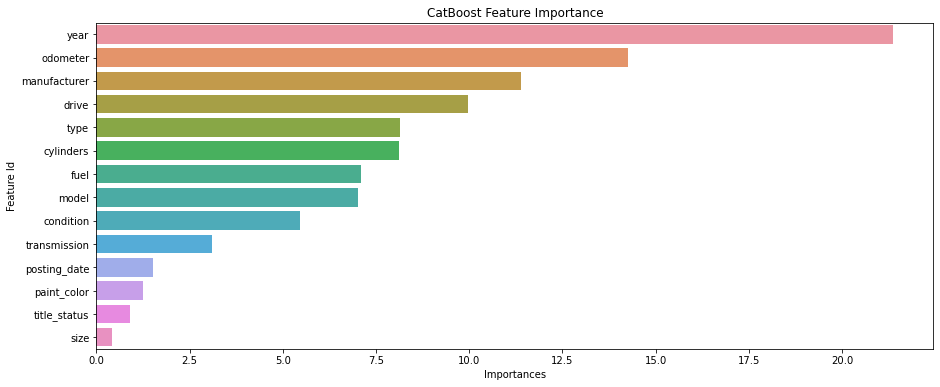

In [70]:
importances = pd.DataFrame(cbr_rgs.get_feature_importance(prettified=True))
plt.figure(figsize=(15, 6))
sns.barplot(data=importances.sort_values('Importances', ascending=False), x='Importances', y='Feature Id')
plt.title('CatBoost Feature Importance')

### Catboost random grid search on data_v9_2 - 2

This time, let us try to increase the number of parameters randomly selected

In [71]:
%%time

grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs_2 = CatBoostRegressor(task_type='GPU', verbose=200, random_seed=SEED)

grid_search_result_2 = cbr_rgs_2.randomized_search(grid,
                                        X=train_data,
                                        n_iter=15,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21614.1958155	test: 21528.6577486	best: 21528.6577486 (0)	total: 19.8ms	remaining: 2.95s
149:	learn: 6880.8091888	test: 6763.5673348	best: 6763.5673348 (149)	total: 3.41s	remaining: 0us
bestTest = 6763.567335
bestIteration = 149
0:	loss: 6763.5673348	best: 6763.5673348 (0)	total: 3.64s	remaining: 51s
0:	learn: 20351.0235428	test: 20268.8687301	best: 20268.8687301 (0)	total: 25ms	remaining: 6.22s
200:	learn: 6139.4400293	test: 6033.3309851	best: 6033.3309851 (200)	total: 5.43s	remaining: 1.32s
249:	learn: 6062.6290198	test: 5956.0312751	best: 5956.0312751 (249)	total: 6.92s	remaining: 0us
bestTest = 5956.031275
bestIteration = 249
1:	loss: 5956.0312751	best: 5956.0312751 (1)	total: 10.7s	remaining: 1m 9s
0:	learn: 19460.1047089	test: 19380.2762151	best: 19380.2762151 (0)	total: 30.2ms	remaining: 15.1s
200:	learn: 5988.1954291	test: 5881.4543953	best: 5881.4543953 (200)	total: 5.46s	remaining: 8.13s
400:	learn: 5748.3609521	test: 5649.2570713	best: 5649.2570713 (400)	total: 11.

In [72]:
y_pred_train_cbr_rgs_2 = cbr_rgs_2.predict(train_data)
y_pred_valid_cbr_rgs_2 = cbr_rgs_2.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs_2, y_pred_valid_cbr_rgs_2)

------ Train Scores ------
R2 Score: 0.9453762482415499
Mean Absolute Error: 1831.9639123757026
Mean Squared Error: 9150404.958954263
Root Mean Squared Error: 3024.9636293605686
------ Validation Scores ------
R2 Score: 0.9039591609817855
Mean Absolute Error: 2199.3688101145754
Mean Squared Error: 16003471.9201987
Root Mean Squared Error: 4000.4339664839736


In [73]:
cbr_rgs_2.save_model('data_v9_catboost_2')

In [74]:
grid_search_result_2['params']

{'depth': 10, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}

Text(0.5, 1.0, 'CatBoost Feature Importance')

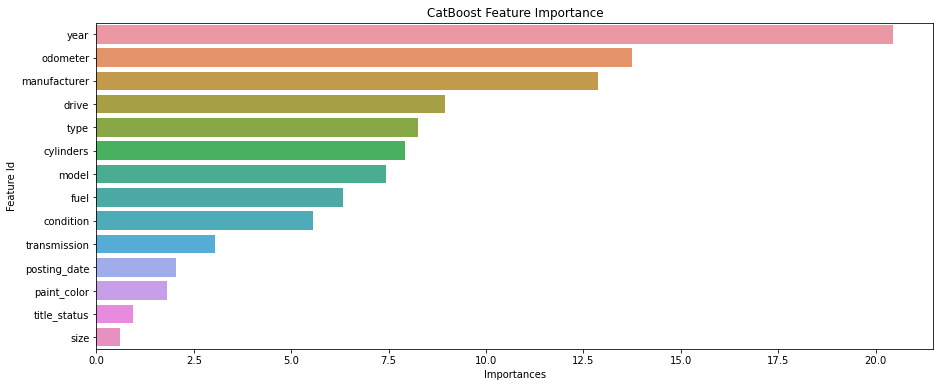

In [75]:
importances_2 = pd.DataFrame(cbr_rgs_2.get_feature_importance(prettified=True))
plt.figure(figsize=(15, 6))
sns.barplot(data=importances_2.sort_values('Importances', ascending=False), x='Importances', y='Feature Id')
plt.title('CatBoost Feature Importance')

### Catboost random grid search on data_v9_2 - 3

This time, let us increase n_iter to 25

In [76]:
%%time

grid = {'learning_rate':[0.01, 0.03, 0.05, 0.1, 0.15],
        'depth':[2, 4, 6, 8, 10],
        'l2_leaf_reg':[1, 3, 5, 7, 9, 11],
        'iterations':[150, 250, 500, 750]}

cbr_rgs_3 = CatBoostRegressor(task_type='GPU', verbose=200, random_seed=SEED)

grid_search_result_3 = cbr_rgs_3.randomized_search(grid,
                                        X=train_data,
                                        n_iter=25,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 21614.1958155	test: 21528.6577486	best: 21528.6577486 (0)	total: 21.3ms	remaining: 3.17s
149:	learn: 6880.8091888	test: 6763.5673348	best: 6763.5673348 (149)	total: 3.6s	remaining: 0us
bestTest = 6763.567335
bestIteration = 149
0:	loss: 6763.5673348	best: 6763.5673348 (0)	total: 3.85s	remaining: 1m 32s
0:	learn: 19460.9167163	test: 19381.0866972	best: 19381.0866972 (0)	total: 21.5ms	remaining: 3.2s
149:	learn: 6131.9782347	test: 6018.6047044	best: 6018.6047044 (149)	total: 3.4s	remaining: 0us
bestTest = 6018.604704
bestIteration = 149
1:	loss: 6018.6047044	best: 6018.6047044 (1)	total: 7.42s	remaining: 1m 25s
0:	learn: 20351.0235428	test: 20268.8687301	best: 20268.8687301 (0)	total: 26.3ms	remaining: 6.55s
200:	learn: 6139.4400293	test: 6033.3309851	best: 6033.3309851 (200)	total: 5.42s	remaining: 1.32s
249:	learn: 6062.6290198	test: 5956.0312751	best: 5956.0312751 (249)	total: 6.68s	remaining: 0us
bestTest = 5956.031275
bestIteration = 249
2:	loss: 5956.0312751	best: 5956.03

In [77]:
y_pred_train_cbr_rgs_3 = cbr_rgs_3.predict(train_data)
y_pred_valid_cbr_rgs_3 = cbr_rgs_3.predict(valid_data)

print_scores(y_train, y_valid, y_pred_train_cbr_rgs_3, y_pred_valid_cbr_rgs_3)

------ Train Scores ------
R2 Score: 0.9453762482415499
Mean Absolute Error: 1831.9639123757026
Mean Squared Error: 9150404.958954263
Root Mean Squared Error: 3024.9636293605686
------ Validation Scores ------
R2 Score: 0.9039591609817855
Mean Absolute Error: 2199.3688101145754
Mean Squared Error: 16003471.9201987
Root Mean Squared Error: 4000.4339664839736


In [78]:
grid_search_result_3['params']

{'depth': 10, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}